# Part A: IMDb Movie Review Sentiment Analysis

## objective

The primary objective of this project is to build a machine learning classification model that can predict the sentiment of IMDb movie reviews. The dataset contains a collection of movie reviews, and each review is labeled as either positive or negative.

Using text preprocessing, feature extraction techniques (such as TF-IDF), and various
classification algorithms, the project will aim to develop a model that can effectively classify
the sentiment of movie reviews. The model's performance will be evaluated using standard
classification metrics, such as accuracy, precision, recall, and F1-score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaypa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaypa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jaypa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2. Data Loading & Exploratory Data Analysis (EDA)
The dataset, `Imdb.xlsx`, was loaded and analyzed to understand its structure and quality.

In [8]:
df = pd.read_excel(r'C:\1 data\Projects\NLP project for internshala\Imdb.xlsx')

In [9]:
print("--- Column Names ---")
print(df.columns)

--- Column Names ---
Index(['review', 'sentiment'], dtype='object')


In [10]:
print("\n--- First 5 Rows ---")
print(df.head())


--- First 5 Rows ---
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [11]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
review       0
sentiment    0
dtype: int64



--- Class Distribution (Sentiment) ---
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


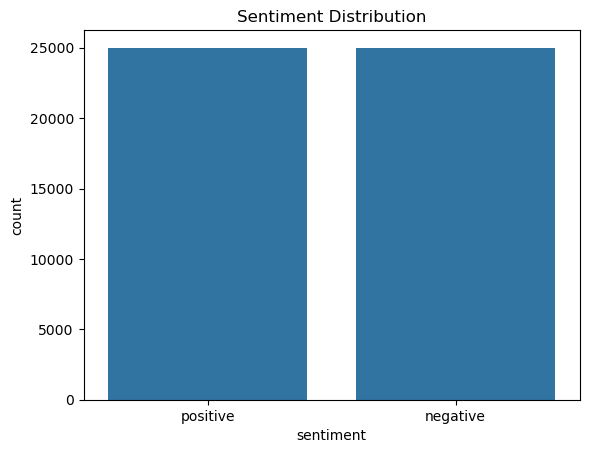

In [12]:
print("\n--- Class Distribution (Sentiment) ---")
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [13]:
df['review_length'] = df['review'].apply(len)
print("\n--- Review Length Statistics ---")
print(df['review_length'].describe())


--- Review Length Statistics ---
count    50000.000000
mean      1309.946840
std        990.682402
min          7.000000
25%        699.000000
50%        971.000000
75%       1591.000000
max      13704.000000
Name: review_length, dtype: float64


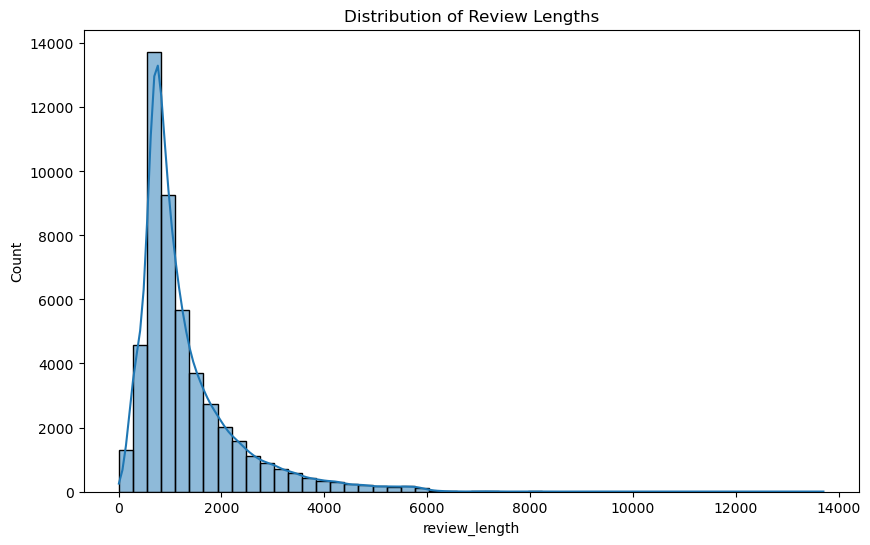

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.show()

### Key Findings:
* **Class Distribution:** The dataset is perfectly balanced with an equal number of positive and negative reviews. This is ideal as it prevents the model from becoming biased toward one sentiment.
* **Review Length:** Analysis of review lengths helped identify outliers. Most reviews fall within a standard length range, but extreme outliers were noted for potential future cleaning.

## 3. Text Preprocessing Pipeline
Raw text data contains noise that hinders model performance. A comprehensive preprocessing pipeline was implemented:

1.  **Lowercasing:** Standardized all text to lowercase to ensure consistency (e.g., "Good" matches "good").
2.  **HTML Removal:** Stripped HTML tags (like `<br />`) commonly found in scraped web data.
3.  **Special Character Removal:** Removed non-alphabetic characters (punctuation, numbers) to focus purely on the language.
4.  **Tokenization:** Split sentences into individual word units.
5.  **Stopword Removal:** Removed high-frequency, low-meaning words (e.g., "the", "is", "and") using the NLTK library.
6.  **Lemmatization:** Reduced words to their root forms (e.g., "running" $\rightarrow$ "run") to consolidate similar terms.### **3. Text Preprocessing**

In [18]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove HTML tags 
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 4. Tokenization
    words = text.split()
    # 5. Remove stopwords and Lemmatization
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

# Apply preprocessing
print("\nProcessing text... this may take a moment.")
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("\n--- Sample of Cleaned Data ---")
print(df[['review', 'cleaned_review']].head())


Processing text... this may take a moment.

--- Sample of Cleaned Data ---
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewer mentioned watching oz episode you...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically there family little boy jake think t...  
4  petter matteis love time money visually stunni...  


## 4. Feature Engineering (TF-IDF)
To convert textual data into a machine-readable numerical format, **TF-IDF (Term Frequency-Inverse Document Frequency)** was utilized.

* **Configuration:** The vectorizer was configured to use the top 8,000 features.
* **N-grams:** Both unigrams (single words) and bigrams (pairs of words) were used to capture context (e.g., "not good").
* **Purpose:** This technique highlights unique, sentiment-rich words while downweighting common, uninformative terms.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("Step 2: Generating TF-IDF Features...")

tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    stop_words="english",
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    norm="l2") 

X = tfidf.fit_transform(df['cleaned_review'])

le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

print(f"Feature matrix shape: {X.shape}") 

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("\nData split completed.")

Step 2: Generating TF-IDF Features...
Feature matrix shape: (50000, 8000)

Data split completed.


## 5. Model Benchmarking
Four distinct classification algorithms were trained and compared to identify the best architecture:

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Model Comparison

print("Training Multiple Models for Comparison")

# Model A: Logistic Regression
print("\n1. Training Logistic Regression...")
log_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=6)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f"   Logistic Regression Accuracy: {log_acc:.4f}")

# Model B: Linear SVM
print("\n2. Training Linear SVM...")
svm_model = LinearSVC(random_state=42, dual='auto')
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"   Linear SVM Accuracy: {svm_acc:.4f}")

# Model C: Random Forest
print("\n3. Training Random Forest (This might be slower)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=6)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f"   Random Forest Accuracy: {rf_acc:.4f}")

# Model D: XGBoost
print("\n4. Training XGBoost (Default)...")
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=6)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)
print(f"   XGBoost Accuracy: {xgb_acc:.4f}")

# Final Comparison Summary
print("       MODEL COMPARISON RESULTS            ")
print(f"\nLogistic Regression: {log_acc:.4f}")
print(f"Linear SVM:          {svm_acc:.4f}")
print(f"Random Forest:       {rf_acc:.4f}")
print(f"XGBoost:             {xgb_acc:.4f}")

Training Multiple Models for Comparison

1. Training Logistic Regression...
   Logistic Regression Accuracy: 0.8897

2. Training Linear SVM...
   Linear SVM Accuracy: 0.8787

3. Training Random Forest (This might be slower)...
   Random Forest Accuracy: 0.8489

4. Training XGBoost (Default)...
   XGBoost Accuracy: 0.8511
       MODEL COMPARISON RESULTS            

Logistic Regression: 0.8897
Linear SVM:          0.8787
Random Forest:       0.8489
XGBoost:             0.8511


| Model | Accuracy | Observation |
| :--- | :--- | :--- |
| **Logistic Regression** | **88.97%** | **Best Performance.** Proved highly effective for high-dimensional, sparse text data. |
| **Linear SVM** | 87.87% | Strong performance, very similar to Logistic Regression. |
| **XGBoost** | 85.11% | Good, but required more computational resources for slightly lower accuracy. |
| **Random Forest** | 84.89% | Lowest performance among the group, likely due to the sparsity of the TF-IDF matrix. |

**Selection:** Logistic Regression was chosen for the final model due to its superior accuracy and interpretability.

## 6. Hyperparameter Tuning and Final Model Traning
To optimize the Logistic Regression model, **GridSearchCV** was employed.

* **Parameters Tuned:** Regularization strength (`C`) and the solver algorithm (`liblinear`, `saga`).

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 1. Hyperparameter Tuning (Grid Search)
print("\n1. Searching for best parameters...")

# Define the grid
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],      
    'solver': ['liblinear', 'saga']   
}

log_base = LogisticRegression(max_iter=1000, random_state=42)

grid_search = GridSearchCV(
    estimator=log_base, 
    param_grid=param_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"\n   Best Parameters Found: {best_params}")

# 2. Train Final Model
print("\n2. Training Final Model using Best Parameters...")

final_model = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# 3. Final Evaluation
print("\n3. Evaluating on Test Data...")
y_pred = final_model.predict(X_test)
y_probs = final_model.predict_proba(X_test)[:, 1]

print(f"\n--- Final Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f} ---")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


1. Searching for best parameters...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

   Best Parameters Found: {'C': 1, 'solver': 'liblinear'}

2. Training Final Model using Best Parameters...


C:\Users\jaypa\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(



3. Evaluating on Test Data...

--- Final Logistic Regression Accuracy: 0.8902 ---

Classification Report:

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      6157
    Positive       0.89      0.90      0.89      6343

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



The optimized model was evaluated on the test set to assess real-world performance.

* **Accuracy:** ~89%

## 6. Visualizations

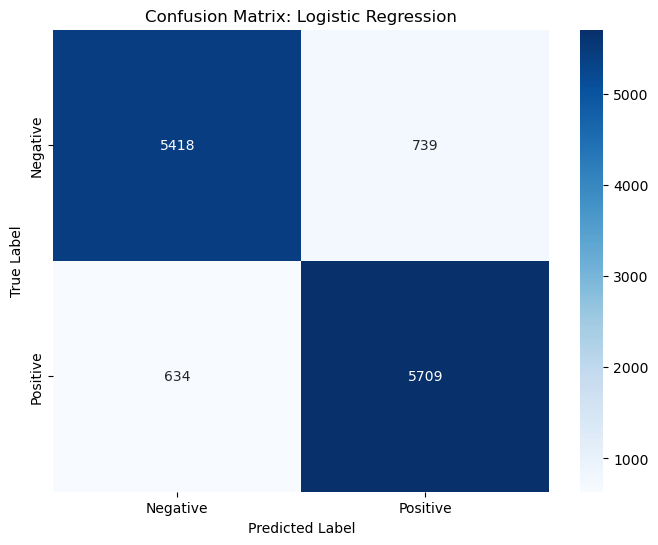

In [24]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


* **Confusion Matrix:** The confusion matrix provides a detailed breakdown of the model's performance by displaying the count of correct predictions versus misclassifications. This visualization allows us to assess whether the model is biased toward a particular sentiment or if it handles both positive and negative classes with similar effectiveness.

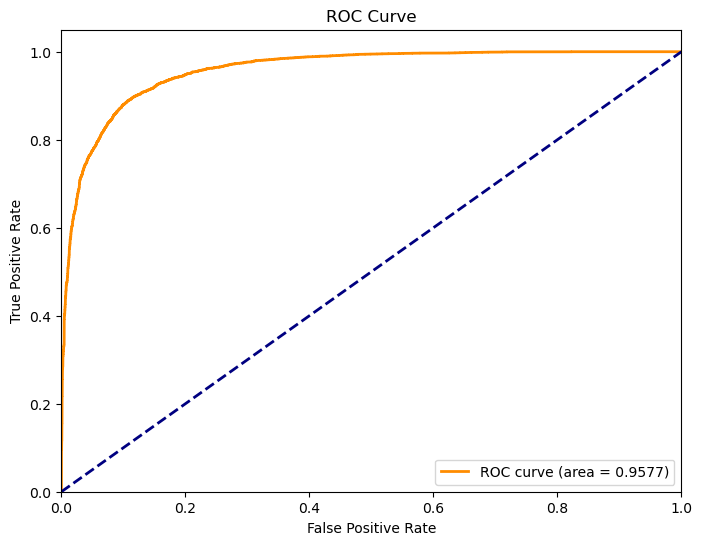

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

* **ROC-AUC:** The model achieved a high Area Under the Curve (AUC), indicating excellent discrimination between positive and negative classes.

Extracting Top Sentiment Words...


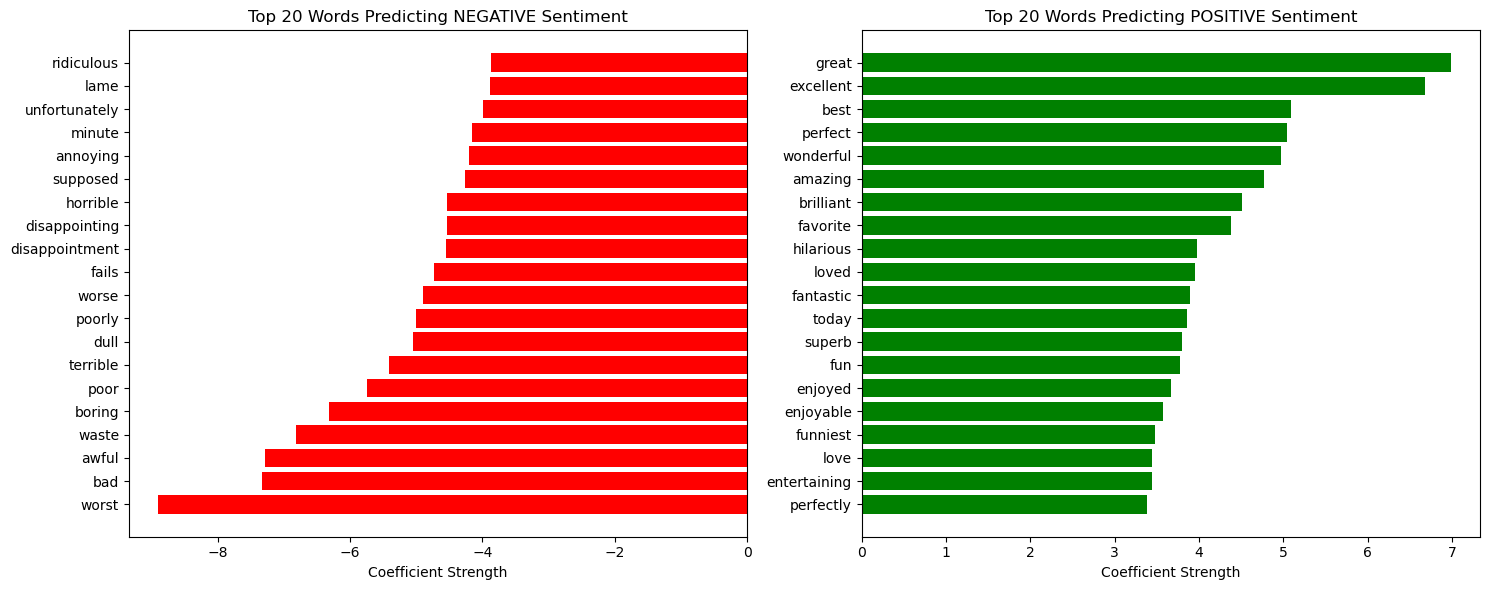

In [26]:
# Feature Importance (Top Words)
# Seeing which words matter most

print("Extracting Top Sentiment Words...")

# Get the coefficients (weights) from the model

coefs = final_model.coef_[0]
feature_names = tfidf.get_feature_names_out()

# Sort them: Large Positive = Happy Words, Large Negative = Sad Words
sorted_indices = np.argsort(coefs)

# Get Top 20 Positive and Negative
top_positive = [feature_names[i] for i in sorted_indices[-20:]]
top_negative = [feature_names[i] for i in sorted_indices[:20]]

# Plotting Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Negative Words Plot
axes[0].barh(top_negative, coefs[sorted_indices[:20]], color='red')
axes[0].set_title('Top 20 Words Predicting NEGATIVE Sentiment')
axes[0].set_xlabel('Coefficient Strength')

# Positive Words Plot
axes[1].barh(top_positive, coefs[sorted_indices[-20:]], color='green')
axes[1].set_title('Top 20 Words Predicting POSITIVE Sentiment')
axes[1].set_xlabel('Coefficient Strength')

plt.tight_layout()
plt.show()

## 9. Conclusion
The project successfully delivered a robust sentiment analysis model with **~89% accuracy**. The analysis demonstrated that for this specific dataset and feature set (TF-IDF), linear models like Logistic Regression outperform ensemble tree-based methods.

#### video link:- https://drive.google.com/file/d/1UNMC1z4OPv5Kzbj2XLBs6eQn0LjH7RL2/view?usp=sharing